<a href="https://colab.research.google.com/github/AIAerospace/DeepLearning/blob/main/8-CNN/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autoencoders

4 tipos de autoencoders con el MNIST dataset

1. Vanilla autoencoders
2. Multilayer autoencoder
3. Convolutional autoencoder
4. Regularized autoencoder

## Librerias

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import to_categorical

## Dataset

No necesitamos las etiquetas porque no vamos a clasificar

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Normalizamos

In [3]:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Flatten para las redes de capas densas

In [4]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

___

# **Vanilla Autoencoder**

### Creamos la red

Tres capas: Input - encoded - decoded

In [5]:
input_size = 784
hidden_size = 64
output_size = 784

In [6]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 784)                 │          50,960 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,200 (395.31 KB)

 Trainable params: 101,200 (395.31 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenar

In [7]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0748 - val_loss: 0.0224
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0197 - val_loss: 0.0127
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0086
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065 - val_loss: 0.0055


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


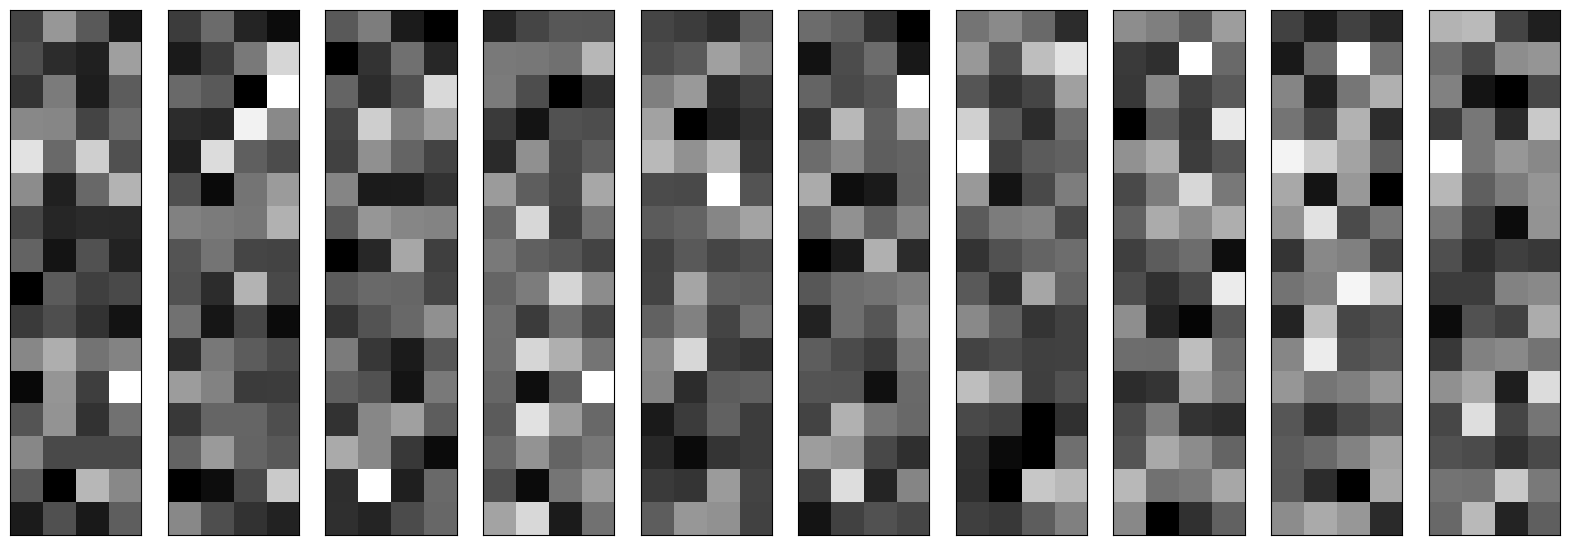

In [8]:
conv_encoder = Model(x, h)
encoded_imgs = conv_encoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Predicción

In [9]:
decoded_imgs = autoencoder.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### Plot

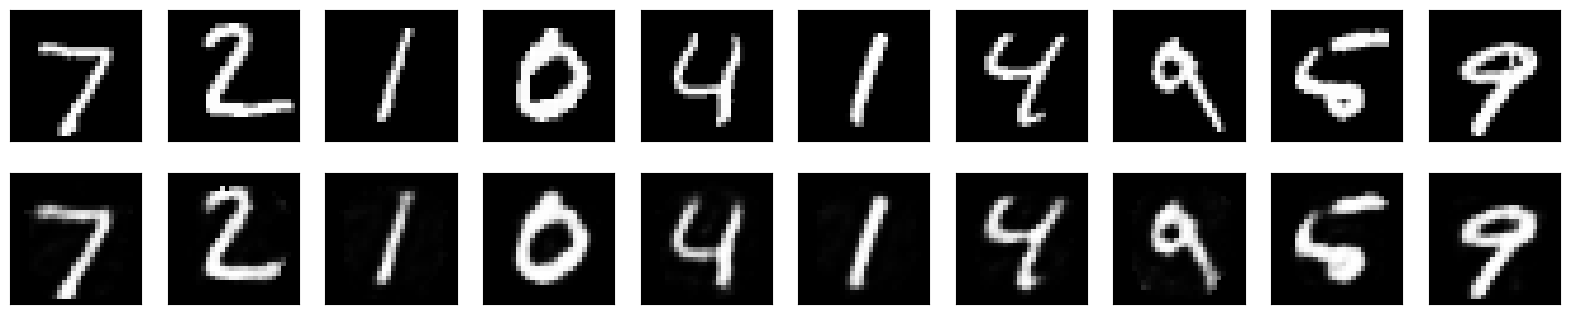

In [10]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


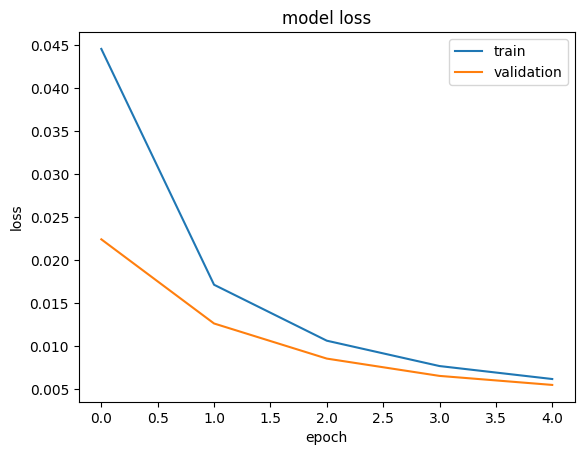

In [11]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

---

# **Multilayer autoencoder**

### Create the network

We extend the idea of the first network to more layers

In [12]:
input_size = 784
hidden_size = 128
code_size = 64

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

### Train the network

In [13]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.0682 - val_loss: 0.0183
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_loss: 0.0121
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0100
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0100 - val_loss: 0.0088
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_loss: 0.0079


### Predict on the test set

In [14]:
decoded_imgs = autoencoder.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


### Plot

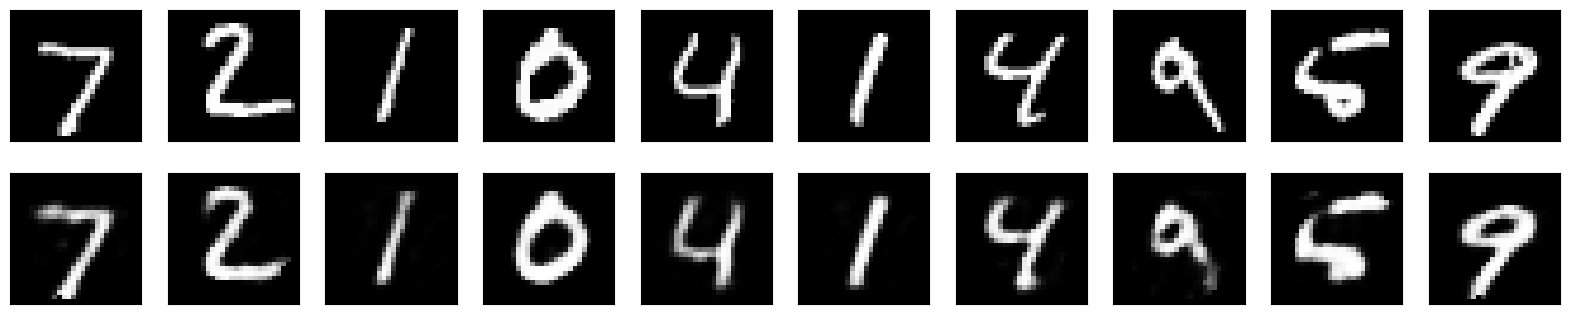

In [15]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


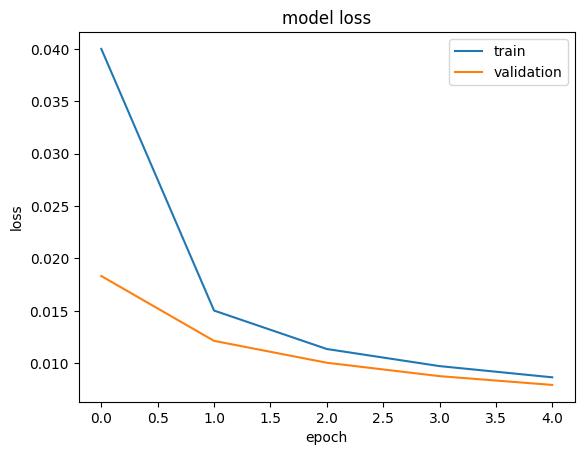

In [16]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

# **Convolutional autoencoder**

In [17]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Create the network

This network does not take flattened vectors as an input but images

In [18]:
x = Input(shape=(28, 28,1))

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
h = MaxPooling2D((2, 2), padding='same')(conv1_3)


# Decoder
conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Train

In [39]:
epochs = 10
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2481 - val_loss: 0.2459
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2450 - val_loss: 0.2434
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2431 - val_loss: 0.2414
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2411 - val_loss: 0.2396
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2394 - val_loss: 0.2380
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2380 - val_loss: 0.2365
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2360 - val_loss: 0.2352
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2343 - val_loss: 0.2339
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2339 - val_loss: 0.2327
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2327 - val_loss: 0.2316


In [40]:
decoded_imgs = autoencoder.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Plot

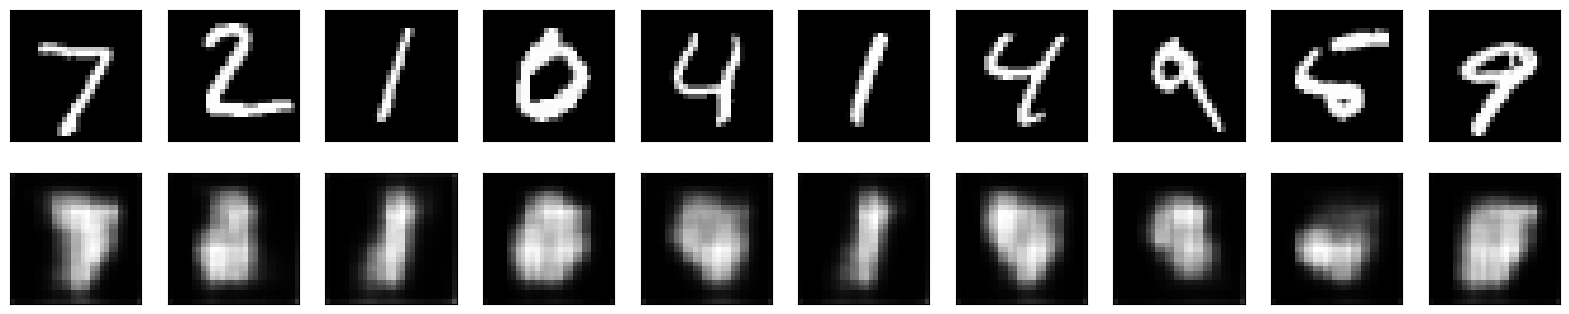

In [41]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


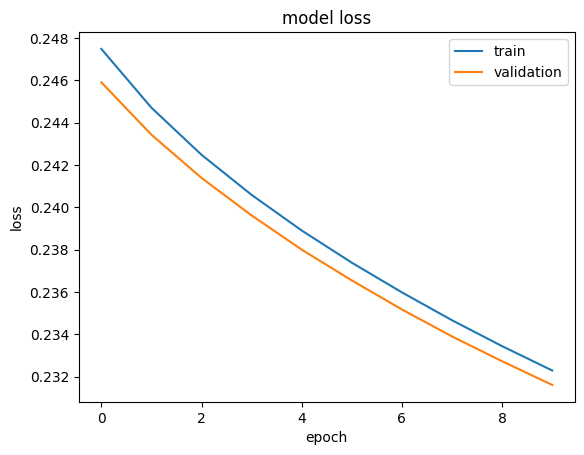

In [42]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

# **Regularized autoencoder**

Two types of regularization are described :
- Sparse autoencoder
- Denoising autoencoder

## 1. Sparse autoencoder

### Create the network

In [43]:
input_size = 784
hidden_size = 32
output_size = 784

In [44]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

In [45]:
epochs = 15
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/15


ValueError: Input 0 of layer "functional_4" is incompatible with the layer: expected shape=(None, 784), found shape=(None, 28, 28)

### Predict on the test set

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

### Plot

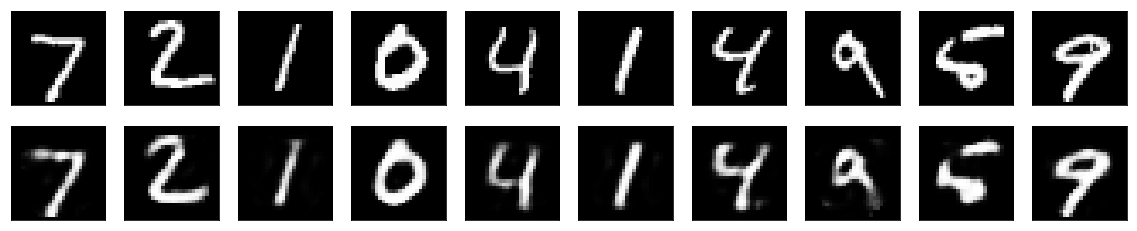

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


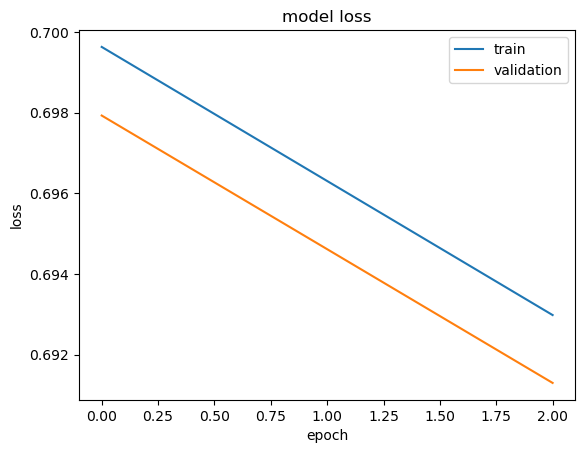

In [ ]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## 2. Denoising autoencoder

In [46]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

### Create noisy data

In [78]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

### Create the network

In [79]:
x = Input(shape=(28, 28, 1))

# Encoder
conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
h = MaxPooling2D((2, 2), padding='same')(conv1_2)


# Decoder
conv2_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

### Train the network

In [80]:
epochs = 150
batch_size = 128

history = autoencoder.fit(X_train_noisy, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_noisy, X_test))

Epoch 1/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.6766 - val_loss: 0.6254
Epoch 2/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6017 - val_loss: 0.5395
Epoch 3/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5262 - val_loss: 0.5119
Epoch 4/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5053 - val_loss: 0.5023
Epoch 5/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4963 - val_loss: 0.4929
Epoch 6/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4868 - val_loss: 0.4829
Epoch 7/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4765 - val_loss: 0.4713
Epoch 8/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4645 - val_loss: 0.4572
Epoch 9/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4502 - val_loss: 0.4392
Epoch 10/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4310 - val_loss: 0.4165
Epoch 11/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4079 - val_loss: 0.3889
Epoch 12/150
469/469 ━━━━━━━━━━━━━━━━━━━━

In [81]:
decoded_imgs = autoencoder.predict(X_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### Plot

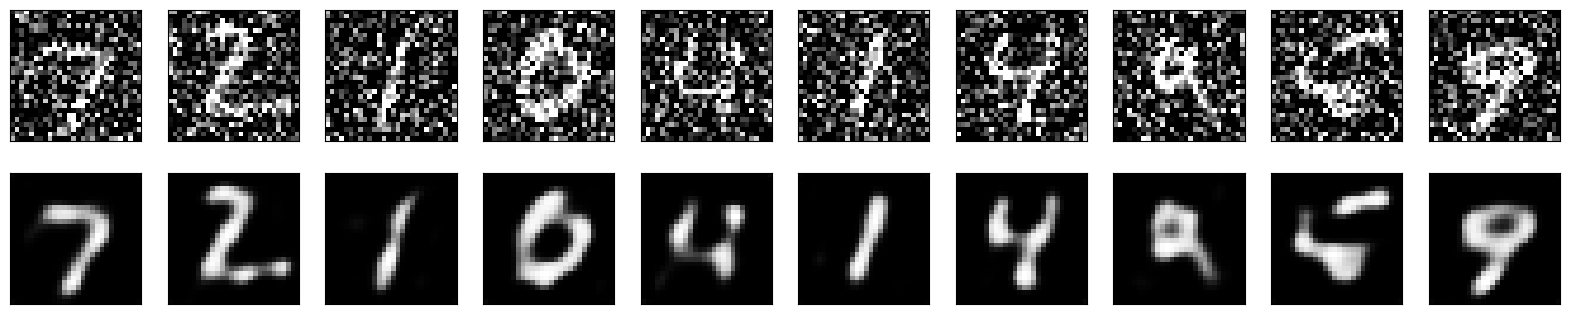

In [82]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Plot the losses

dict_keys(['loss', 'val_loss'])


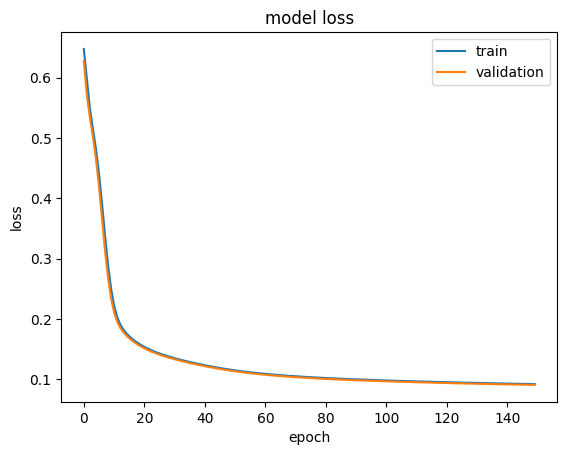

In [77]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

---